In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import glob
import matplotlib as mpl
import os

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, precision_recall_curve, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from scipy.stats import entropy, spearmanr, pearsonr

In [8]:
os.chdir('/project/primate_msa/egrn/tfbs_prediction')

## Functions

In [2]:
def get_pr(data, score_cols, label_col):
    labels = data[label_col]
    
    no_skill = labels.sum() / len(labels)
    auc_prs = {'noskill':no_skill}
    rocs = {}
    
    for score_col in score_cols:

        scores = data[score_col]
        
        precision, recall, _ = precision_recall_curve(labels, scores)
        auc1 = auc(recall, precision)
        auc_prs[score_col] = (recall, precision, auc1)

        roc = roc_auc_score(labels, scores)
        rocs[score_col] = roc

    return auc_prs, rocs
    
def plot_pr(auc_prs, title, output=False):
    
    f = plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.plot([0, 1], [auc_prs['noskill'], auc_prs['noskill']], linestyle='--', label=f'No skill (AUC = {auc_prs["noskill"]:.2f})')

    for var in auc_prs:
        if var != 'noskill':
            (recall, precision, auc1) = auc_prs[var]
            plt.plot(recall, precision, marker='.', label=f'{var} (AUC = {auc1:.2f})', markersize=1)
            
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)
    if output:
        plt.savefig(output, dpi=150, pad_inches=0.05, bbox_inches="tight")
        
    plt.show()

def label_point(x, y, val, ax, xlims, ylims, offset):
    a = pd.concat({'x': pd.Series(x), 'y': pd.Series(y), 'val': pd.Series(val)}, axis=1)
    for i, point in a.iterrows():

        if point['x'] >= xlims[1] or point['y'] >= ylims[1]:
            ax.text(point['x']+offset, point['y']+offset, str(point['val']))
        elif point['x'] <= xlims[0] or point['y'] <= ylims[0]:
            ax.text(point['x']+offset, point['y']+offset, str(point['val']))

## Input

In [9]:
enhancers = pd.read_csv('data/all_regions.bed', sep='\t', names=['chr', 'start', 'end', 'enh_id'], header=None, dtype=str)
enhancers['coord'] = enhancers['chr'] + ':' + enhancers['start'] + '-' + enhancers['end']
enhancers.index = enhancers.enh_id

with open('data/test_sets.pk', 'rb') as f:
    test_sets = pickle.load(f)
with open('data/leaderboard_sets.pk', 'rb') as f:
    leaderboard_sets = pickle.load(f)

In [14]:
# 0 for unbound, 1 for ambigous and 3 for bound. Changing to a binary bound/unbound labeling
for key in test_sets:
    test_sets[key]['label'] = test_sets[key]['label'] > 2

for key in leaderboard_sets:
    leaderboard_sets[key]['label'] = leaderboard_sets[key]['label'] > 2

In [15]:
# Couldn't train a model for NANOG
del test_sets['NANOG']

In [17]:
nt_embeddings = pd.read_csv('data/embeddings.csv')

In [18]:
nt_embeddings.index = nt_embeddings.enh_id
nt_embeddings.drop(['Unnamed: 0', 'chr', 'start', 'end', 'enh_id', 'coord'], axis=1, inplace=True)
emb_cols = [f'emb_{i}' for i in range(1024)]
nt_embeddings.columns = emb_cols

In [20]:
# Models
general_model = xgb.XGBRegressor()
general_model.load_model('models/general_models/general_base_model.json')

tf_tuned_models = {}
for file in glob.glob('models/tf_models/*_base_model.json'):
    tf_name = file.split('/')[-1].split('_')[0]
    model = xgb.XGBRegressor()
    model.load_model(file)
    tf_tuned_models[tf_name] = model
del tf_tuned_models['general']

with open('models/tf_models_nogeneral.pk', 'rb') as f:
    tf_only_models = pickle.load(f)

/home/aksu/miniconda3/envs/condajupyter/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:17:02] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [21]:
# Features
emb_cols = [f'emb_{i}' for i in range(1024)]
gen_features = ['maxpwm', 'cons', 'crup', 'crup_mean', 'crup_delta', 'remap', 'tf_exp', 'tf_activity',
            'tfact_crupcor_coef', 'tfact_crupcor_pval', 'trap', 'atac_min', 'atac_max', 'atac_mean', 'atac_mean_mean',
            'atac_delta_min', 'atac_delta_max', 'atac_delta_mean', 'tobias_avg', 'delta_tobias_avg', 'tobias_mean_mean', 'tobias_count',
           'cot_hits_0', 'cot_hits_1', 'cot_hits_2', 'cot_hits_3',
           'cot_maxpwm_0', 'cot_maxpwm_1', 'cot_maxpwm_2', 'cot_maxpwm_3']
tfonly_features = ['maxpwm', 'cons', 'crup', 'crup_mean', 'crup_delta', 'remap', 'tf_exp', 'tf_activity',
            'tfact_crupcor_coef', 'tfact_crupcor_pval', 'trap', 'atac_min', 'atac_max', 'atac_mean', 'atac_mean_mean',
            'atac_delta_min', 'atac_delta_max', 'atac_delta_mean', 'tobias_avg', 'delta_tobias_avg', 'tobias_mean_mean', 'tobias_count',
           'cot_hits_0', 'cot_hits_1', 'cot_hits_2', 'cot_hits_3', 'cot_hits_4', 'cot_hits_5',
           'cot_maxpwm_0', 'cot_maxpwm_1', 'cot_maxpwm_2', 'cot_maxpwm_3', 'cot_maxpwm_4', 'cot_maxpwm_5']
tftuned_features = gen_features + ['xgb_general']
nt_features = emb_cols + gen_features

## Figure 1

In [22]:
def get_predictions(dataset, tf, runtfonly=True):
    # Model predictions
    dataset['xgb_general'] = general_model.predict(dataset[gen_features])
    dataset['tf_tuned'] = tf_tuned_models[tf].predict(dataset[tftuned_features])
    if runtfonly:
        dataset['tf_only'] = tf_only_models[tf].predict_proba(dataset[tfonly_features])[:,1]
    
    # Transformer criss-cross
    model1 = xgb.Booster()
    model2 = xgb.Booster()
    model3 = xgb.Booster()
    model4 = xgb.Booster()
    ab = True
    try:
        model1.load_model(f'/project/primate_msa/egrn/transformer/models/v3/{tf}_a1.json')
        model2.load_model(f'/project/primate_msa/egrn/transformer/models/v3/{tf}_a2.json')
        model3.load_model(f'/project/primate_msa/egrn/transformer/models/v3/{tf}_b1.json')
        model4.load_model(f'/project/primate_msa/egrn/transformer/models/v3/{tf}_b2.json')
    except:
        ab = False
        model1.load_model(f'/project/primate_msa/egrn/transformer/models/v3/{tf}_a.json')
        model2.load_model(f'/project/primate_msa/egrn/transformer/models/v3/{tf}_b.json')

    t_data = xgb.DMatrix(dataset.loc[:, nt_features])
    pred1 = model1.predict(t_data)
    pred2 = model2.predict(t_data)
    if ab:
        pred3 = model3.predict(t_data)
        pred4 = model4.predict(t_data)
    else:
        pred3=np.zeros(shape=len(pred1))
        pred4=np.zeros(shape=len(pred1))
        
    preds = pd.DataFrame([pred1, pred2, pred3, pred4])
    dataset['transformer'] = preds.mean(axis=0).values
    return dataset

In [24]:
all_aucprs = {}
all_rocs = {}
for key in test_sets:
    if key in tf_tuned_models:
        for tissue in test_sets[key]['tissue'].unique():
            tfdf = test_sets[key][test_sets[key].tissue == tissue]
            tfdf = tfdf.merge(nt_embeddings, left_index=True, right_index=True, how='left')
            if tissue == 'induced_pluripotent_stem_cell':
                tissue = 'iPSC'
                
            aucpr_features = ['xgb_general', 'tf_tuned', 'tf_only', 'transformer']

            tfdf_predictions = get_predictions(tfdf, key)
            result = get_pr(tfdf_predictions, aucpr_features, 'label')

            all_aucprs[f'{key}-{tissue}'] = pd.DataFrame(result[0]).T.iloc[:,2]
            all_rocs[f'{key}-{tissue}'] = pd.Series(result[1])
            

In [25]:
# Leaderboard set
all_aucprs_leaderboard = {}
for key in leaderboard_sets:
    if key in tf_tuned_models:
        for tissue in leaderboard_sets[key]['tissue'].unique():
            tfdf = leaderboard_sets[key][leaderboard_sets[key].tissue == tissue]
            tfdf = tfdf.merge(nt_embeddings, left_index=True, right_index=True, how='left')            
            aucpr_features = ['xgb_general', 'tf_tuned', 'transformer']
            
            tfdf_predictions = get_predictions(tfdf, key, False)
            result = get_pr(tfdf_predictions, aucpr_features, 'label')
            
            all_aucprs_leaderboard[f'{key}-{tissue}'] = pd.DataFrame(result[0]).T.iloc[:,2]

In [26]:
all_aucprs_dream = {}
for key in test_sets:
    if key in tf_tuned_models:
        for tissue in test_sets[key]['tissue'].unique():
            tfdf = test_sets[key][test_sets[key].tissue == tissue]
            tfdf = tfdf.merge(nt_embeddings, left_index=True, right_index=True, how='left')
            tfdf = get_predictions(tfdf, key)
            
            for team in ['jteam', 'autosome', 'factornet']:
                try:
                    df = pd.read_csv(f'data/dream_contestants/{team}/F.{key}.{tissue}.tab.testset.summary', sep='\t', index_col = 0, names=[f'mean_{team}', f'max_{team}'])
                    tfdf = tfdf.merge(df, how='left', left_index=True, right_index=True)
                except:
                    print('not found:', key, tissue, team)
                    tfdf[[f'mean_{team}', f'max_{team}']] = 0
                    
            # For labeling
            if tissue == 'induced_pluripotent_stem_cell':
                tissue = 'iPSC'
            aucpr_features = ['transformer', 'mean_jteam', 'mean_autosome', 'mean_factornet']
            result = get_pr(tfdf, aucpr_features, 'label')
            all_aucprs_dream[f'{key}-{tissue}'] = pd.DataFrame(result[0]).T.iloc[:,2]

dreams = pd.DataFrame(all_aucprs_dream)
dreams.loc['mean_autosome', 'HNF4A-liver'] = None # This file was not uploaded by the team

not found: HNF4A liver autosome


In [27]:
# Cosmetic parameters
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
name_dict = {'noskill': 'No skill', 'xgb_general': 'General', 'tf_only': 'TF-only', 'tf_tuned': 'TF-tuned', 'transformer': 'TF+transformer'}

## Figure 1

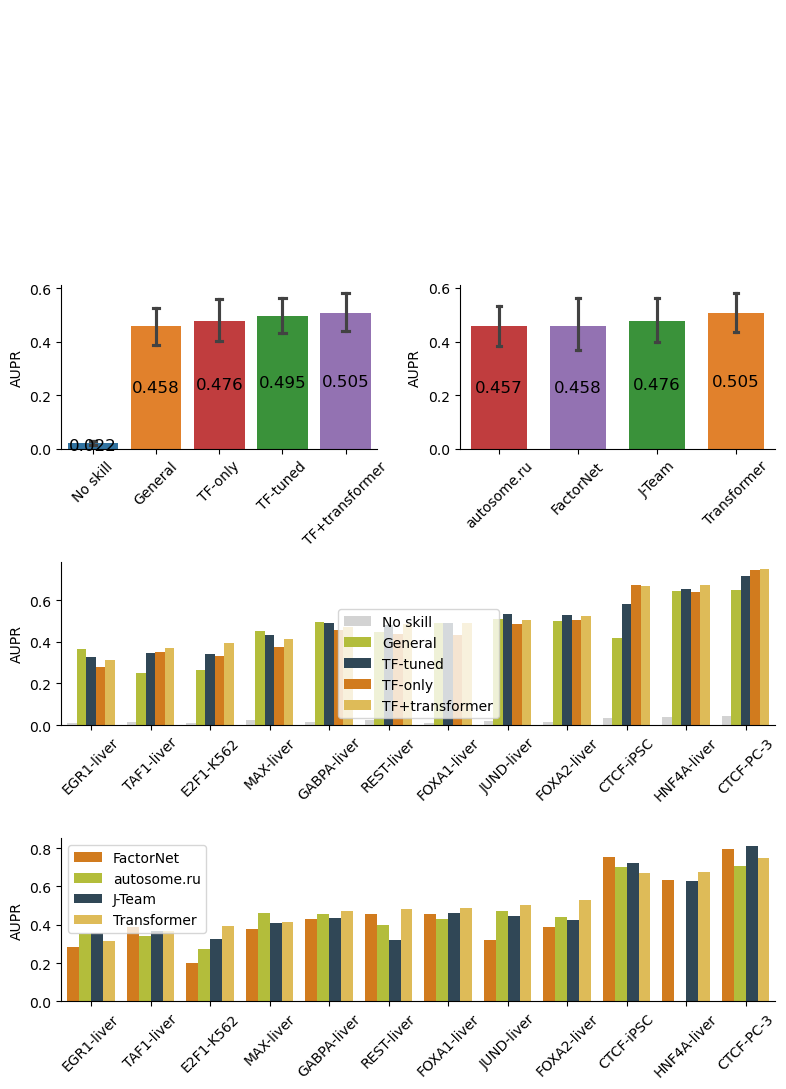

In [29]:
fig1 = plt.figure(figsize=(8,11))

ax1a = fig1.add_subplot(4, 2, 1)
ax1b = fig1.add_subplot(4, 2, 2)
ax1c = fig1.add_subplot(4, 2, 3)
ax1d = fig1.add_subplot(4, 2, 4)
ax1e = fig1.add_subplot(4, 1, 3)
ax1f = fig1.add_subplot(4, 1, 4)

ax1a.set_axis_off()
ax1b.set_axis_off()

#1c
sns.barplot(pd.DataFrame(all_aucprs).T, order=['noskill', 'xgb_general', 'tf_only', 'tf_tuned', 'transformer'], capsize=0.1, ax=ax1c)
for container in ax1c.containers:
    ax1c.bar_label(container,  fmt='%.3f', label_type='center', fontsize=12)

ax1c.set_xticks(list(name_dict.keys()))
ax1c.set_xticklabels(name_dict.values(), rotation=45)
ax1c.set_ylabel('AUPR')

#1d
sns.barplot(pd.DataFrame(dreams).T, order=['mean_autosome', 'mean_factornet', 'mean_jteam', 'transformer'], capsize=0.05, ax=ax1d, width=0.7)
for container in ax1d.containers:
    ax1d.bar_label(container,  fmt='%.3f', label_type='center', fontsize=12)

name_dict2 = {'mean_autosome':'autosome.ru', 'mean_factornet':'FactorNet', 'mean_jteam':'J-Team', 'transformer':'Transformer'}
ax1d.set_xticks(list(name_dict2.keys()))
ax1d.set_xticklabels(name_dict2.values(), rotation=45)

ax1d.set_ylabel('AUPR')

#1e
plotdf = pd.DataFrame(all_aucprs).stack().to_frame('value').reset_index()
plotdf.rename(columns={'level_0':'Model', 'level_1':'tf-tissue'},inplace=True)

palette ={'noskill':'lightgrey', 'xgb_general':'#c6d325', 'tf_only':'#ef7c00', 'tf_tuned':'#29485d', 'transformer':'#f4c542'}
sns.barplot(data=plotdf, x='tf-tissue', y='value', hue='Model', order=pd.DataFrame(all_aucprs).loc['transformer'].sort_values().index, palette=palette, ax=ax1e)
#ax1e.set_xticks(rotation=0, ha='center')
ax1e.set_xlabel('')
ax1e.set_ylabel('AUPR')
ax1e.tick_params(axis='x', labelrotation=45)

handles, previous_labels = ax1e.get_legend_handles_labels()
ax1e.legend(handles=handles, labels=[name_dict[x] for x in previous_labels])

#1f
plotdf = pd.DataFrame(dreams).stack().to_frame('value').reset_index()
plotdf.rename(columns={'level_0':'Model', 'level_1':'tf-tissue'},inplace=True)

palette ={'mean_autosome':'#c6d325', 'mean_factornet':'#ef7c00', 'mean_jteam':'#29485d', 'transformer':'#f4c542'}
sns.barplot(data=plotdf, x='tf-tissue', y='value', hue='Model', order=pd.DataFrame(dreams).loc['transformer'].sort_values().index, hue_order=['mean_factornet', 'mean_autosome', 'mean_jteam','transformer'], palette=palette, ax=ax1f)
ax1f.tick_params(axis='x', labelrotation=45)
handles, previous_labels = ax1f.get_legend_handles_labels()
ax1f.legend(handles=handles, labels=[name_dict2[x] for x in previous_labels])
ax1f.set_xlabel('')
ax1f.set_ylabel('AUPR')

plt.tight_layout()
#plt.savefig('fig1.pdf', dpi=300)

## Figure 3

In [36]:
leave_out = {'base_model':[],
             'noatac_tobias':['atac_min', 'atac_max', 'atac_mean', 'atac_mean_mean','atac_delta_min', 'atac_delta_max', 'atac_delta_mean', 'tobias_avg','delta_tobias_avg', 'tobias_mean_mean', 'tobias_count'],
             'nopwm_tobiascount_cotracte':['maxpwm', 'trap', 'tobias_count','cot_hits_0', 'cot_hits_1', 'cot_hits_2', 'cot_hits_3','cot_maxpwm_0', 'cot_maxpwm_1', 'cot_maxpwm_2', 'cot_maxpwm_3'],
             'nocrup':['crup', 'crup_mean', 'crup_delta'],
             'noremap':['remap'],
             'notf_exp_activity_cor':['tf_exp', 'tf_activity', 'tfact_crupcor_coef', 'tfact_crupcor_pval'],
             'dreamlike':['crup', 'crup_mean', 'crup_delta', 'remap'],
             'notf_activity':['tf_activity'],
             'nocotracte':['cot_hits_0', 'cot_hits_1', 'cot_hits_2', 'cot_hits_3','cot_maxpwm_0', 'cot_maxpwm_1', 'cot_maxpwm_2', 'cot_maxpwm_3'],
             'notobias':['tobias_avg','delta_tobias_avg', 'tobias_mean_mean', 'tobias_count']
             }

general_models = {}
tf_models = {}
for case in leave_out:
    model = xgb.XGBRegressor()
    model.load_model(f'models/general_models/general_{case}.json')
    general_models[case] = model
    
    for tf in test_sets.keys():
        tf_model = xgb.XGBRegressor()
        tf_model.load_model(f'models/tf_models/{tf}_{case}.json')
        tf_models[(tf, case)] = tf_model

    for tf in leaderboard_sets.keys():
        try:
            tf_model = xgb.XGBRegressor()
            tf_model.load_model(f'models/tf_models/{tf}_{case}.json')
            tf_models[(tf, case)] = tf_model
        except:
            pass

In [37]:
aucpr_features = ['general_model'] + list(leave_out.keys())

all_aucprs_leaveout = {}
for key in test_sets:
    if key in tf_tuned_models:
        for tissue in test_sets[key]['tissue'].unique():
            tfdf = test_sets[key][test_sets[key].tissue == tissue].copy()
            tfdf['general_model'] = general_models['base_model'].predict(tfdf[gen_features])

            for case in leave_out:
                tf_model = tf_models[(key, case)]
                cur_features = [x for x in gen_features if x not in leave_out[case]]
                nox_general = general_models[case].predict(tfdf[cur_features])
                tfdf['xgb_general'] = nox_general
                tf_model_pred = tf_model.predict(tfdf[cur_features +['xgb_general']])
                tfdf[case] = tf_model_pred
                
            # For labeling
            if tissue == 'induced_pluripotent_stem_cell':
                tissue = 'iPSC'
            result = get_pr(tfdf, aucpr_features, 'label')
            all_aucprs_leaveout[f'{key}-{tissue}'] = pd.DataFrame(result[0]).T.iloc[:,2]

In [38]:
aucpr_features = ['general_model'] + list(leave_out.keys())

all_aucprs_leaveout_lb = {}
for key in leaderboard_sets:
    if key in tf_tuned_models:
        for tissue in leaderboard_sets[key]['tissue'].unique():
            tfdf = leaderboard_sets[key][leaderboard_sets[key].tissue == tissue].copy()
            tfdf['general_model'] = general_models['base_model'].predict(tfdf[gen_features])

            for case in leave_out:
                tf_model = tf_models[(key, case)]
                cur_features = [x for x in gen_features if x not in leave_out[case]]
                nox_general = general_models[case].predict(tfdf[cur_features])
                tfdf['xgb_general'] = nox_general
                tf_model_pred = tf_model.predict(tfdf[cur_features +['xgb_general']])
                tfdf[case] = tf_model_pred
                
            # For labeling
            if tissue == 'induced_pluripotent_stem_cell':
                tissue = 'iPSC'
            result = get_pr(tfdf, aucpr_features, 'label')
            all_aucprs_leaveout_lb[f'{key}-{tissue}'] = pd.DataFrame(result[0]).T.iloc[:,2]

In [39]:
all_aucprs_leaveout2 = pd.DataFrame(all_aucprs_leaveout) - pd.DataFrame(all_aucprs_leaveout).loc['base_model']
all_aucprs_leaveout2_lb = pd.DataFrame(all_aucprs_leaveout_lb) - pd.DataFrame(all_aucprs_leaveout_lb).loc['base_model']

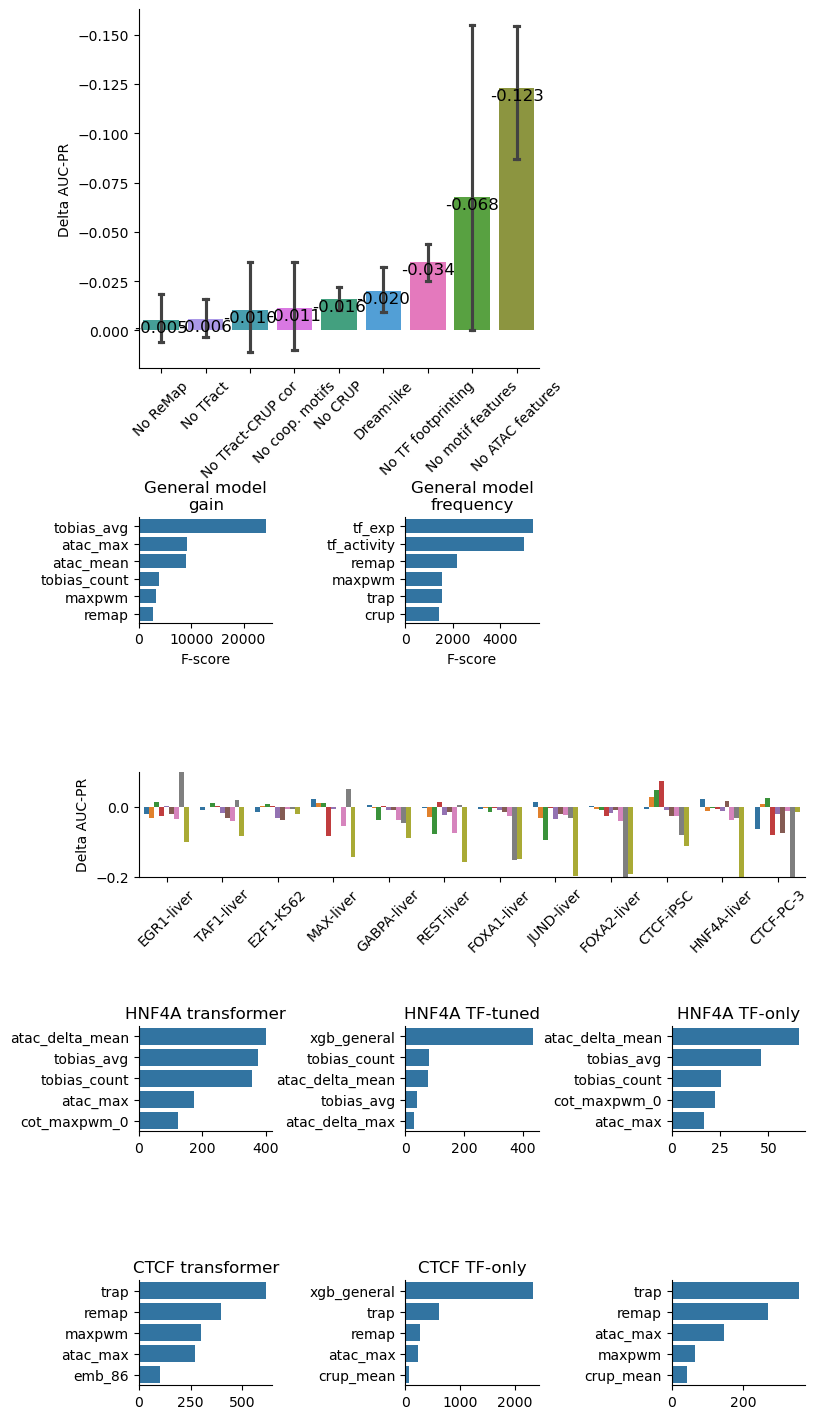

In [41]:
fig2 = plt.figure(figsize=(8,14))

ax2a = plt.subplot2grid((6, 3), (0, 0), rowspan=2, colspan=2)
ax2b = plt.subplot2grid((6, 3), (2, 0))
ax2b2 = plt.subplot2grid((6, 3), (2, 1))
ax2c = plt.subplot2grid((6, 3), (3, 0), colspan=3)
ax2d = plt.subplot2grid((6, 3), (4, 0))
ax2d2 = plt.subplot2grid((6, 3), (4, 1))
ax2d3 = plt.subplot2grid((6, 3), (4, 2))
ax2e = plt.subplot2grid((6, 3), (5, 0))
ax2e2 = plt.subplot2grid((6, 3), (5, 1))
ax2e3 = plt.subplot2grid((6, 3), (5, 2))

#2a
sns.barplot(all_aucprs_leaveout2.T, order=['noremap', 'notf_activity', 'notf_exp_activity_cor', 'nocotracte', 'nocrup', 'dreamlike', 'notobias', 'nopwm_tobiascount_cotracte', 'noatac_tobias'], capsize=0.1, ax=ax2a)
for container in ax2a.containers:
    ax2a.bar_label(container,  fmt='%.3f', label_type='edge', fontsize=12)

ax2a.set_ylabel('Delta AUC-PR')
name_dict3 = {'noremap':'No ReMap', 'notf_activity':'No TFact', 'notf_exp_activity_cor':'No TFact-CRUP cor', 'nocrup':'No CRUP', 'dreamlike':'Dream-like',
              'nopwm_tobiascount_cotracte':'No motif features','noatac_tobias':'No ATAC features', 'notobias':'No TF footprinting', 'nocotracte':'No coop. motifs'}
ax2a.set_xticks(list(name_dict3.keys()))
ax2a.set_xticklabels(name_dict3.values(), rotation=45)

ax2a.tick_params(axis='x', labelrotation=45)
ax2a.invert_yaxis()

#2b
scores = general_model.get_booster().get_score(importance_type='gain')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:6]}), orient='y', ax=ax2b)
scores = general_model.get_booster().get_score(importance_type='weight')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:6]}), orient='y', ax=ax2b2)
ax2b.set_title('General model\ngain')
ax2b2.set_title('General model\nfrequency')
ax2b.set_ylabel('')
ax2b2.set_ylabel('')
ax2b.set_xlabel('F-score')
ax2b2.set_xlabel('F-score')

'''
xgb.plot_importance(general_model, importance_type='gain',  show_values=False, grid=False, ax=ax2b)
xgb.plot_importance(general_model, importance_type='weight',  show_values=False, grid=False, ax=ax2b2)
ax2b.set_title('by gain')
ax2b2.set_title('by frequency')
ax2b.set_ylabel('')
ax2b2.set_ylabel('')
'''

#2c
plotdf = all_aucprs_leaveout2.stack().to_frame('value').reset_index()
plotdf.rename(columns={'level_0':'Model', 'level_1':'tf-tissue'},inplace=True)

sns.barplot(data=plotdf, x='tf-tissue', y='value', hue='Model', order=pd.DataFrame(dreams).loc['transformer'].sort_values().index,
            hue_order = ['noremap', 'notf_activity', 'notf_exp_activity_cor', 'nocotracte', 'nocrup', 'dreamlike', 'notobias', 'nopwm_tobiascount_cotracte', 'noatac_tobias'], ax=ax2c)
ax2c.set_ylim((-0.2, 0.1))
#sns.move_legend(ax2c, "upper left", bbox_to_anchor=(1, 1))
ax2c.get_legend().remove()
ax2c.set_ylabel('Delta AUC-PR')
ax2c.tick_params(axis='x', labelrotation=45)
ax2c.set_xlabel('')

#2d
model1 = xgb.Booster()
model1.load_model('models/tf_transformer_models/HNF4A_a.json')
scores = model1.get_score(importance_type='gain')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:5]}), orient='y', ax=ax2d)
ax2d.set_title('HNF4A transformer')

scores = tf_tuned_models['HNF4A'].get_booster().get_score(importance_type='gain')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:5]}), orient='y', ax=ax2d2)
ax2d2.set_title('HNF4A TF-tuned')

scores = tf_only_models['HNF4A'].get_booster().get_score(importance_type='gain')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:5]}), orient='y', ax=ax2d3)
ax2d3.set_title('HNF4A TF-only')

#2e
model1 = xgb.Booster()
model1.load_model('models/tf_transformer_models/CTCF_a1.json')
scores = model1.get_score(importance_type='gain')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:5]}), orient='y', ax=ax2e)
ax2e.set_title('CTCF transformer')

scores = tf_tuned_models['CTCF'].get_booster().get_score(importance_type='gain')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:5]}), orient='y', ax=ax2e2)
ax2e2.set_title('CTCF TF-tuned')

scores = tf_only_models['CTCF'].get_booster().get_score(importance_type='gain')
sns.barplot(pd.Series({k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])[:5]}), orient='y', ax=ax2e3)
ax2e2.set_title('CTCF TF-only')


plt.tight_layout(pad=0, w_pad=0, h_pad=0)
#plt.savefig('fig2.pdf', dpi=300)

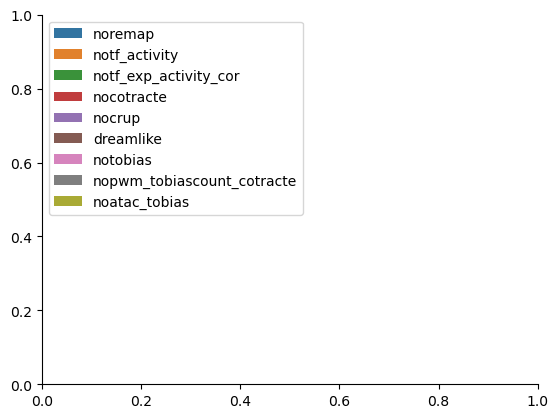

In [42]:
#plt.figure()
plt.legend(*ax2c.get_legend_handles_labels(), loc = 'upper left')
#plt.savefig('fig2c_legend.pdf', dpi=300)

## Figure 4

A) Deeptools top 200 region figure
B) Example region from IGV

In [43]:
selected_tf = 'HNF4A'
selected_tissue = 'liver'

selected_features = ['random', 'crup', 'remap', 'tfact_crupcor_coef', 'maxpwm', 'atac_mean', 'tobias_count', 'transformer']
k = 3000

In [44]:
tfdf = test_sets[selected_tf][test_sets[selected_tf].tissue == selected_tissue]
tfdf = tfdf.merge(nt_embeddings, left_index=True, right_index=True, how='left')
tfdf_predictions = get_predictions(tfdf, selected_tf)

In [595]:
for s in selected_features:
    if s == 'random':
        tfdf_predictions.sample(k)[['chr', 'start', 'end']].to_csv(f'deeptools_{selected_tf}_{selected_tissue}_{s}.bed', index=False, header=None, sep='\t')
    else:
        tfdf_predictions.sort_values(by=s, ascending=False).head(k)[['chr', 'start', 'end']].to_csv(f'deeptools_{selected_tf}_{selected_tissue}_{s}.bed', index=False, header=None, sep='\t')

Text(0.5, 1.0, 'HNF4A prediction in liver')

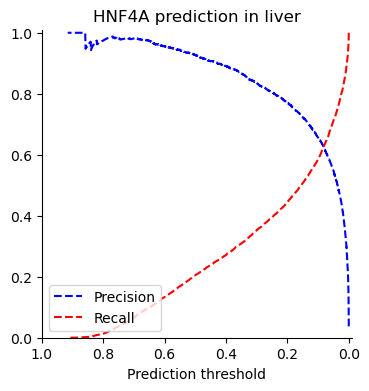

In [45]:
precision, recall, threshold = precision_recall_curve(tfdf_predictions.label, tfdf_predictions.transformer)
threshold *= 2

plt.figure(figsize=(4,4))
plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Prediction threshold')
plt.legend(loc='lower left')
plt.ylim([0,1.01])
plt.xlim([-0.01,1])
plt.legend
#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title('HNF4A prediction in liver')
#plt.savefig('HNF4A_precision_recall.pdf', dpi=300)

In [47]:
with open('data/chosen_encode_tissues.txt', 'r') as f:
    tissues = f.read().strip().split()
crup = pd.read_csv('data/all_regions_crupscores.bed', sep='\t', names=['chr', 'start', 'end', 'enh_id'] + tissues, header=None, index_col='enh_id').drop(columns=['chr', 'start', 'end']).dropna()

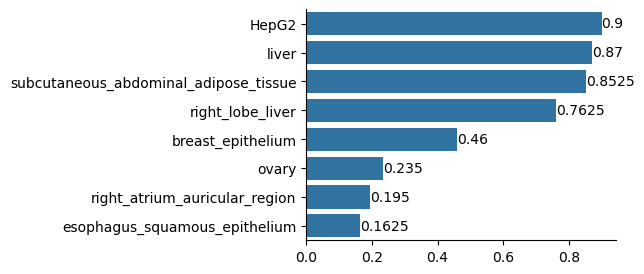

In [49]:
crups = crup.loc[['EH38E1355849','EH38E2817083', 'EH38E2817084', 'EH38E1355852']]
crups = crups.mean(axis=0).sort_values(ascending=False).head(8)

crups

fig, ax = plt.subplots(figsize=(4,3))
sns.barplot(crups, orient='h')
ax.bar_label(ax.containers[0]) # only 1 container needed unless using `hue`
plt.show()
#plt.savefig('fig4_crup_scores.pdf', dpi=300)

## Figure 5

In [53]:
# Why performance is different?

perf = pd.concat([pd.DataFrame(all_aucprs), pd.DataFrame(all_aucprs_leaderboard)], axis=1).loc[['transformer']].T
perf['tf'] = [x.split('-')[0] for x in perf.index]
perf['tissue'] = ['-'.join(x.split('-')[1:]) for x in perf.index]

perf = perf[perf.tf != 'CTCF'] # CTCF is not a TF

In [64]:
tf_act = pd.read_csv('data/tf_activities_fixed.tsv', sep='\t', index_col=0)
tf_act = tf_act*10000
tf_act = pd.DataFrame(StandardScaler().fit_transform(tf_act), index=tf_act.index, columns=tf_act.columns)

bulk_mrna = pd.read_csv('data/tfs_meantpm.tsv', sep='\t', index_col='gene_symbol')
bulk_mrna = bulk_mrna[~bulk_mrna.index.duplicated(keep='first')]
bulk_mrna.drop('gene_id', axis=1, inplace=True)
bulk_mrna.fillna(0, inplace=True)
bulk_mrna = np.log1p(bulk_mrna)
bulk_mrna = bulk_mrna.loc[bulk_mrna.sum(axis=1) > 1,:]

In [65]:
perf['tf_activity'] = perf.apply(lambda x: tf_act.loc[x.tissue, x.tf], axis=1)
perf['tf_activity_entropy'] = perf.apply(lambda x: round(entropy(np.histogram(tf_act[x.tf], bins=15)[0], base=2), 3), axis=1)

perf['tf_expression'] = perf.apply(lambda x: bulk_mrna.loc[x.tf, x.tissue], axis=1)
perf['tf_expression_entropy'] = perf.apply(lambda x: round(entropy(np.histogram(bulk_mrna.loc[x.tf], bins=15)[0], base=2), 3), axis=1)

perf['total_entropy'] = perf['tf_activity_entropy'] + perf['tf_expression_entropy']

In [66]:
perf = perf.convert_dtypes()

In [68]:
chipseq_aucprs = {}
for tf in leaderboard_sets:
    if tf in tf_tuned_models:
        for tissue in leaderboard_sets[tf]['tissue'].unique():
            try:
                chipchip = pd.read_csv(f'data/predict_chipseq_with_chipseq/{tf}_{tissue}.tsv', sep='\t')
            except:
                print(tf, tissue)
                continue
            chipchip['coord'] = chipchip['#chrom'] + ':' + chipchip['start'].astype(str) + '-' + chipchip['end'].astype(str)
            chipchip = chipchip.merge(enhancers, on='coord', how='right')
            chipchip.index = chipchip.enh_id
            
            tfdf = leaderboard_sets[tf][leaderboard_sets[tf].tissue == tissue]
            tfdf['chipseq_fc'] = chipchip.loc[tfdf.index, 'mean']
            aucpr_features = ['chipseq_fc']
            aucprs = get_pr(tfdf.fillna(0), aucpr_features, 'label')
            chipseq_aucprs[(tf, tissue)] = pd.DataFrame(aucprs[0]).T.iloc[:,2]

CTCF GM12878


In [69]:
for tf in test_sets:
    if tf in tf_tuned_models:
        for tissue in test_sets[tf]['tissue'].unique():
            try:
                chipchip = pd.read_csv(f'data/predict_chipseq_with_chipseq/{tf}_{tissue}.tsv', sep='\t')
            except:
                print(tf, tissue)
                continue
            chipchip['coord'] = chipchip['#chrom'] + ':' + chipchip['start'].astype(str) + '-' + chipchip['end'].astype(str)
            chipchip = chipchip.merge(enhancers, on='coord', how='right')
            chipchip.index = chipchip.enh_id
            
            tfdf = test_sets[tf][test_sets[tf].tissue == tissue]
            tfdf['chipseq_fc'] = chipchip.loc[tfdf.index, 'mean']
            aucpr_features = ['chipseq_fc']
            aucprs = get_pr(tfdf.fillna(0), aucpr_features, 'label')
            chipseq_aucprs[(tf, tissue)] = pd.DataFrame(aucprs[0]).T.iloc[:,2]

/scratch/local/ipykernel_29649/2747151143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfdf['chipseq_fc'] = chipchip.loc[tfdf.index, 'mean']


CTCF induced_pluripotent_stem_cell


In [74]:
chipchips = pd.DataFrame(chipseq_aucprs).T
perf['chipseq_perf'] = perf.apply(lambda x: chipchips.loc[(x['tf'], x['tissue']), 'chipseq_fc'], axis=1)
perf['normalized_perf'] = perf.apply(lambda x: x['transformer'] / chipchips.loc[(x['tf'], x['tissue']), 'chipseq_fc'], axis=1)
perf.drop(['ZNF143-K562', 'REST-K562'], inplace=True) # Outliers, very low chipseq performance (< 0.2 AUPR)

In [75]:
perf['scaled_norm'] = perf['normalized_perf']/2
a = perf[['tf', 'transformer', 'chipseq_perf', 'scaled_norm']].sort_values(by='scaled_norm')
a = pd.melt(a.reset_index(), id_vars=['index', 'tf'])

/scratch/local/ipykernel_29649/604220802.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4e.set_xticklabels(a.tf, rotation=45, ha='right')
/scratch/local/ipykernel_29649/604220802.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4e2.set_yticklabels([f'{int(x*200)}%' for x in ax4e.get_yticks()])


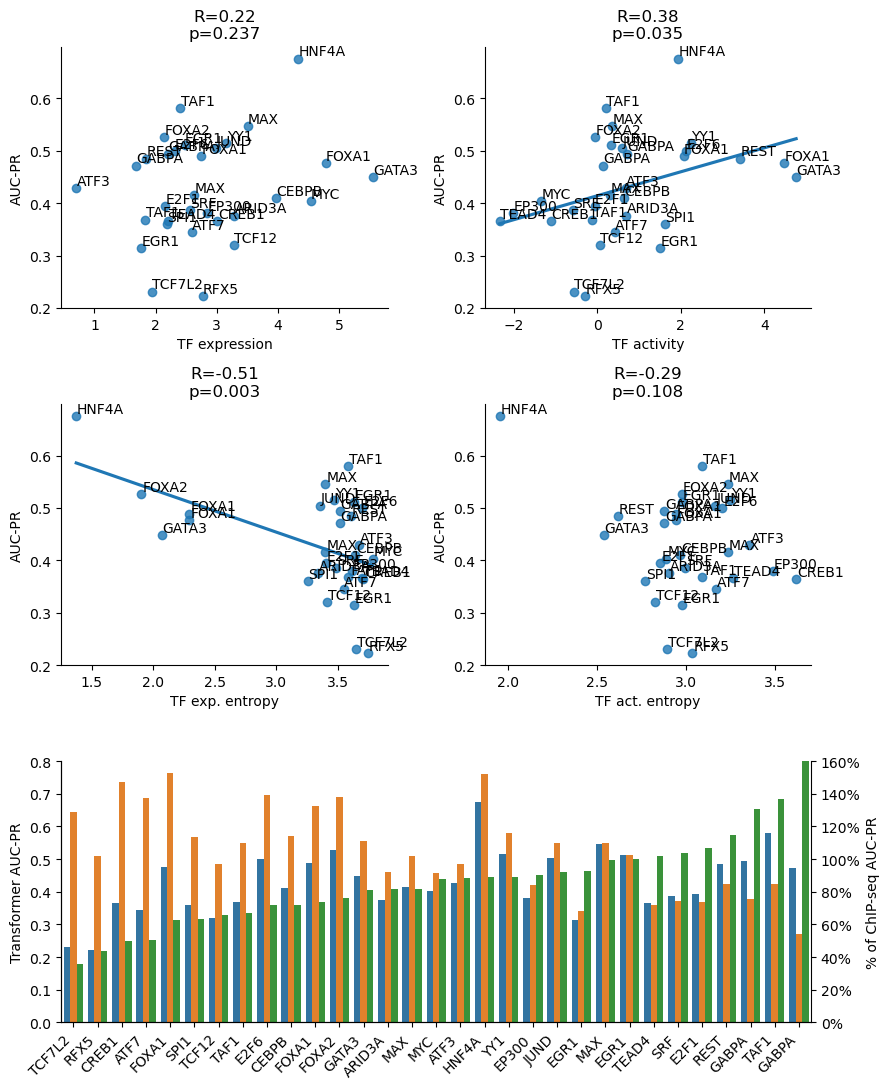

In [76]:
fig4 = plt.figure(figsize=(9,11)) # Actually fig5

ax4a = fig4.add_subplot(3, 2, 1)
ax4b = fig4.add_subplot(3, 2, 2)
ax4c = fig4.add_subplot(3, 2, 3)
ax4d = fig4.add_subplot(3, 2, 4)
ax4e = fig4.add_subplot(3, 1, 3)


#4a
y = 'transformer'
x = 'tf_expression'
sns.regplot(perf, x=x, y=y, ci=None, ax=ax4a, fit_reg=False)
label_point(perf[x], perf[y], perf.tf, ax4a,  (0,0),  (0,0), 0.006)
ax4a.set_ylabel('AUC-PR')
ax4a.set_xlabel('TF expression')
p = pearsonr(perf[x], perf[y])
ax4a.set_title(f'R={p[0]:.2f}\np={p[1]:.3f}')

#4b
y = 'transformer'
x = 'tf_activity'
sns.regplot(perf, x=x, y=y, ci=None, ax=ax4b)
label_point(perf[x], perf[y], perf.tf, ax4b,  (0,0),  (0,0), 0.006)
ax4b.set_ylabel('AUC-PR')
ax4b.set_xlabel('TF activity')
p = pearsonr(perf[x], perf[y])
ax4b.set_title(f'R={p[0]:.2f}\np={p[1]:.3f}')

#4c
y = 'transformer'
x = 'tf_expression_entropy'
sns.regplot(perf, x=x, y=y, ci=None, ax=ax4c)
label_point(perf[x], perf[y], perf.tf, ax4c,  (0,0),  (0,0), 0.006)
ax4c.set_ylabel('AUC-PR')
ax4c.set_xlabel('TF exp. entropy')
p = pearsonr(perf[x], perf[y])
ax4c.set_title(f'R={p[0]:.2f}\np={p[1]:.3f}')

#4d
y = 'transformer'
x = 'tf_activity_entropy'
sns.regplot(perf, x=x, y=y, ci=None, ax=ax4d, fit_reg=False)
label_point(perf[x], perf[y], perf.tf, ax4d,  (0,0),  (0,0), 0.006)
ax4d.set_ylabel('AUC-PR')
ax4d.set_xlabel('TF act. entropy')
p = pearsonr(perf[x], perf[y])
ax4d.set_title(f'R={p[0]:.2f}\np={p[1]:.3f}')

mpl.rcParams['axes.spines.right'] = True

#4e
y = 'transformer'
x = 'chipseq_perf'
sns.barplot(a[a.variable != 'normalized_perf'], x='index', y='value', hue='variable', ax=ax4e, errorbar=None, legend=None)
ax4e.set_ylabel('Transformer AUC-PR')
ax4e.set_xlabel('')
ax4e.set_ylim((0,0.8))
#ax4e.tick_params(axis='x', labelrotation=45, ha='right')

ax4e.set_xticklabels(a.tf, rotation=45, ha='right')

ax4e2 = ax4e.twinx()
ax4e2.set_ylim(ax4e.get_ylim())
ax4e2.set_yticklabels([f'{int(x*200)}%' for x in ax4e.get_yticks()])
ax4e2.set_ylabel('% of ChIP-seq AUC-PR')

plt.tight_layout()
#plt.savefig('fig5.pdf', dpi=300)

mpl.rcParams['axes.spines.right'] = False

## Figure 6

In [77]:
new_tf_tissues = [('liver', 'NR2F2'),('SK-N-SH', 'ISL1'), ('SK-N-SH', 'TFAP2B'), ('liver', 'ZBTB33'),
                 ('liver', 'RXRA'), ('liver', 'RAD21'), ('liver', 'HNF4G'), ('SK-N-SH', 'FOSL2'), ('SK-N-SH', 'NFIC'), ('SK-N-SH', 'PBX3')]

In [92]:
all_aucprs_new_tfs = []
all_performances = []
all_predictions = {}

for (tissue, tf) in new_tf_tissues:
    with open(f'data/new_tfs/{tissue}-{tf}/aucprs.pk', 'rb') as f:
        aucprs = pickle.load(f)

    aucprs = pd.DataFrame(aucprs).T.iloc[:,2]
    performances = pd.read_csv(f'data/new_tfs/{tissue}-{tf}/performance_analysis.csv', index_col=0)
    
    aucprs = aucprs[~aucprs.index.str.contains('model$')]
    del aucprs['transformer_gen']
    aucprs = pd.DataFrame(aucprs)
    aucprs.columns = [tf]
    all_aucprs_new_tfs.append(pd.DataFrame(aucprs))

    performances['predicted_tf'] = tf
    performances['tissue'] = tissue
    all_performances.append(performances)

In [93]:
all_performances = pd.concat(all_performances, axis=0)

In [94]:
all_aucprs_new_tfs = pd.concat(all_aucprs_new_tfs, axis=1)

In [95]:
all_aucprs_new_tfs.loc['mean_tr_perc'] = all_aucprs_new_tfs.loc['mean_tr_models'] / all_aucprs_new_tfs.loc['transformer']
all_performances['normalized_perf'] = all_performances.apply(lambda x: x['performance'] / all_aucprs_new_tfs.loc['chipseq', x['predicted_tf']], axis=1)
all_performances['normalized_perf_tr'] = all_performances.apply(lambda x: x['performance'] / all_aucprs_new_tfs.loc['transformer', x['predicted_tf']], axis=1)
all_performances[['predicted_tf', 'performance']].groupby(by = 'predicted_tf').mean().sort_values(by='performance').index

Index(['ISL1', 'TFAP2B', 'NR2F2', 'HNF4G', 'NFIC', 'PBX3', 'ZBTB33', 'FOSL2',
       'RXRA', 'RAD21'],
      dtype='object', name='predicted_tf')

In [96]:
all_aucprs_new_tfs.drop(['mean_tr_perc', 'tftuned'], inplace=True)

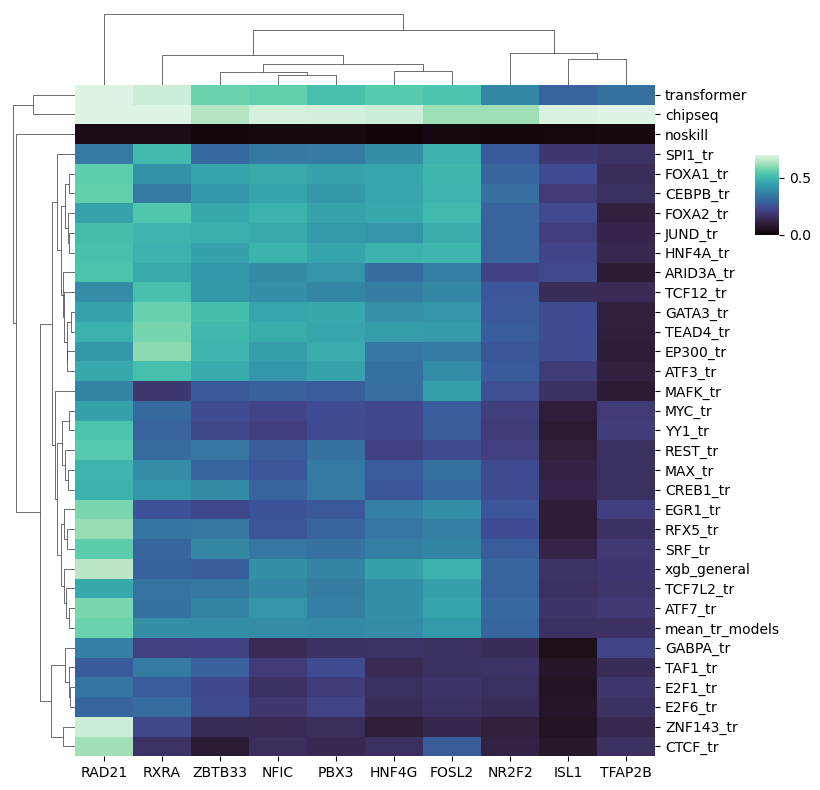

In [ ]:
#newtf2 = newtf_table.div(newtf_table.loc['chipseq'], axis=1).loc[list(transformer_models) + ['xgb_general', 'mean_tr_models', 'transformer']]
#newtf2.index = [x[:-3] if x.endswith('_tr') else x for x in newtf2.index]
clustermap = sns.clustermap(all_aucprs_new_tfs.astype(float), vmin=0, vmax=0.7, cmap='mako', cbar_pos=(0.95, 0.7, .03, .1), dendrogram_ratio=0.1, figsize=(8,8))
#plt.savefig('fig6_clustermap.pdf', dpi=300)

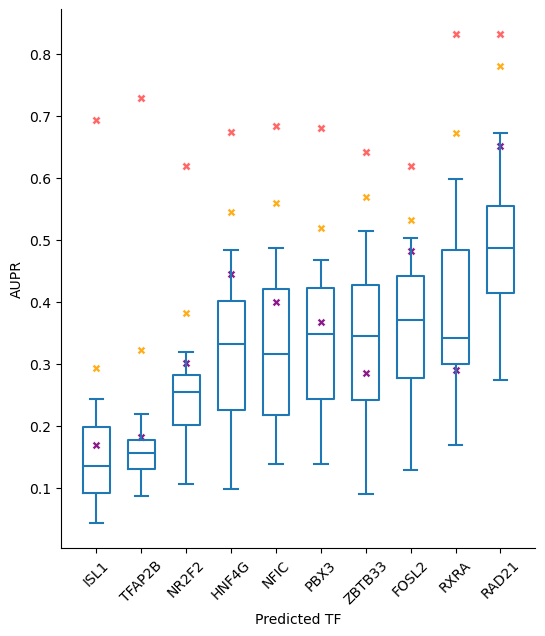

In [99]:
fig5 = plt.figure(figsize=(8,12))
ax5a = plt.subplot2grid((2, 3), (0, 0), colspan=2)

#5a
order = all_performances[['predicted_tf', 'performance']].groupby(by = 'predicted_tf').mean().sort_values(by='performance').index
sns.boxplot(all_performances, x='predicted_tf', y='performance', order=order, fill=False, width=0.6, ax=ax5a)
sns.scatterplot(x=all_aucprs_new_tfs.columns, y=all_aucprs_new_tfs.loc['chipseq'], color='red', marker="X", alpha=0.6, ax=ax5a)
sns.scatterplot(x=all_aucprs_new_tfs.columns, y=all_aucprs_new_tfs.loc['transformer'], color='orange', marker="X", alpha=0.9, ax=ax5a)
sns.scatterplot(x=all_aucprs_new_tfs.columns, y=all_aucprs_new_tfs.loc['xgb_general'], color='purple', marker="X", alpha=0.9, ax=ax5a)
ax5a.set_xlabel('Predicted TF')
ax5a.set_ylabel('AUPR')
ax5a.tick_params(axis='x', labelrotation=45)


plt.tight_layout()
#plt.savefig('fig6.pdf', dpi=300)

## Figure 2

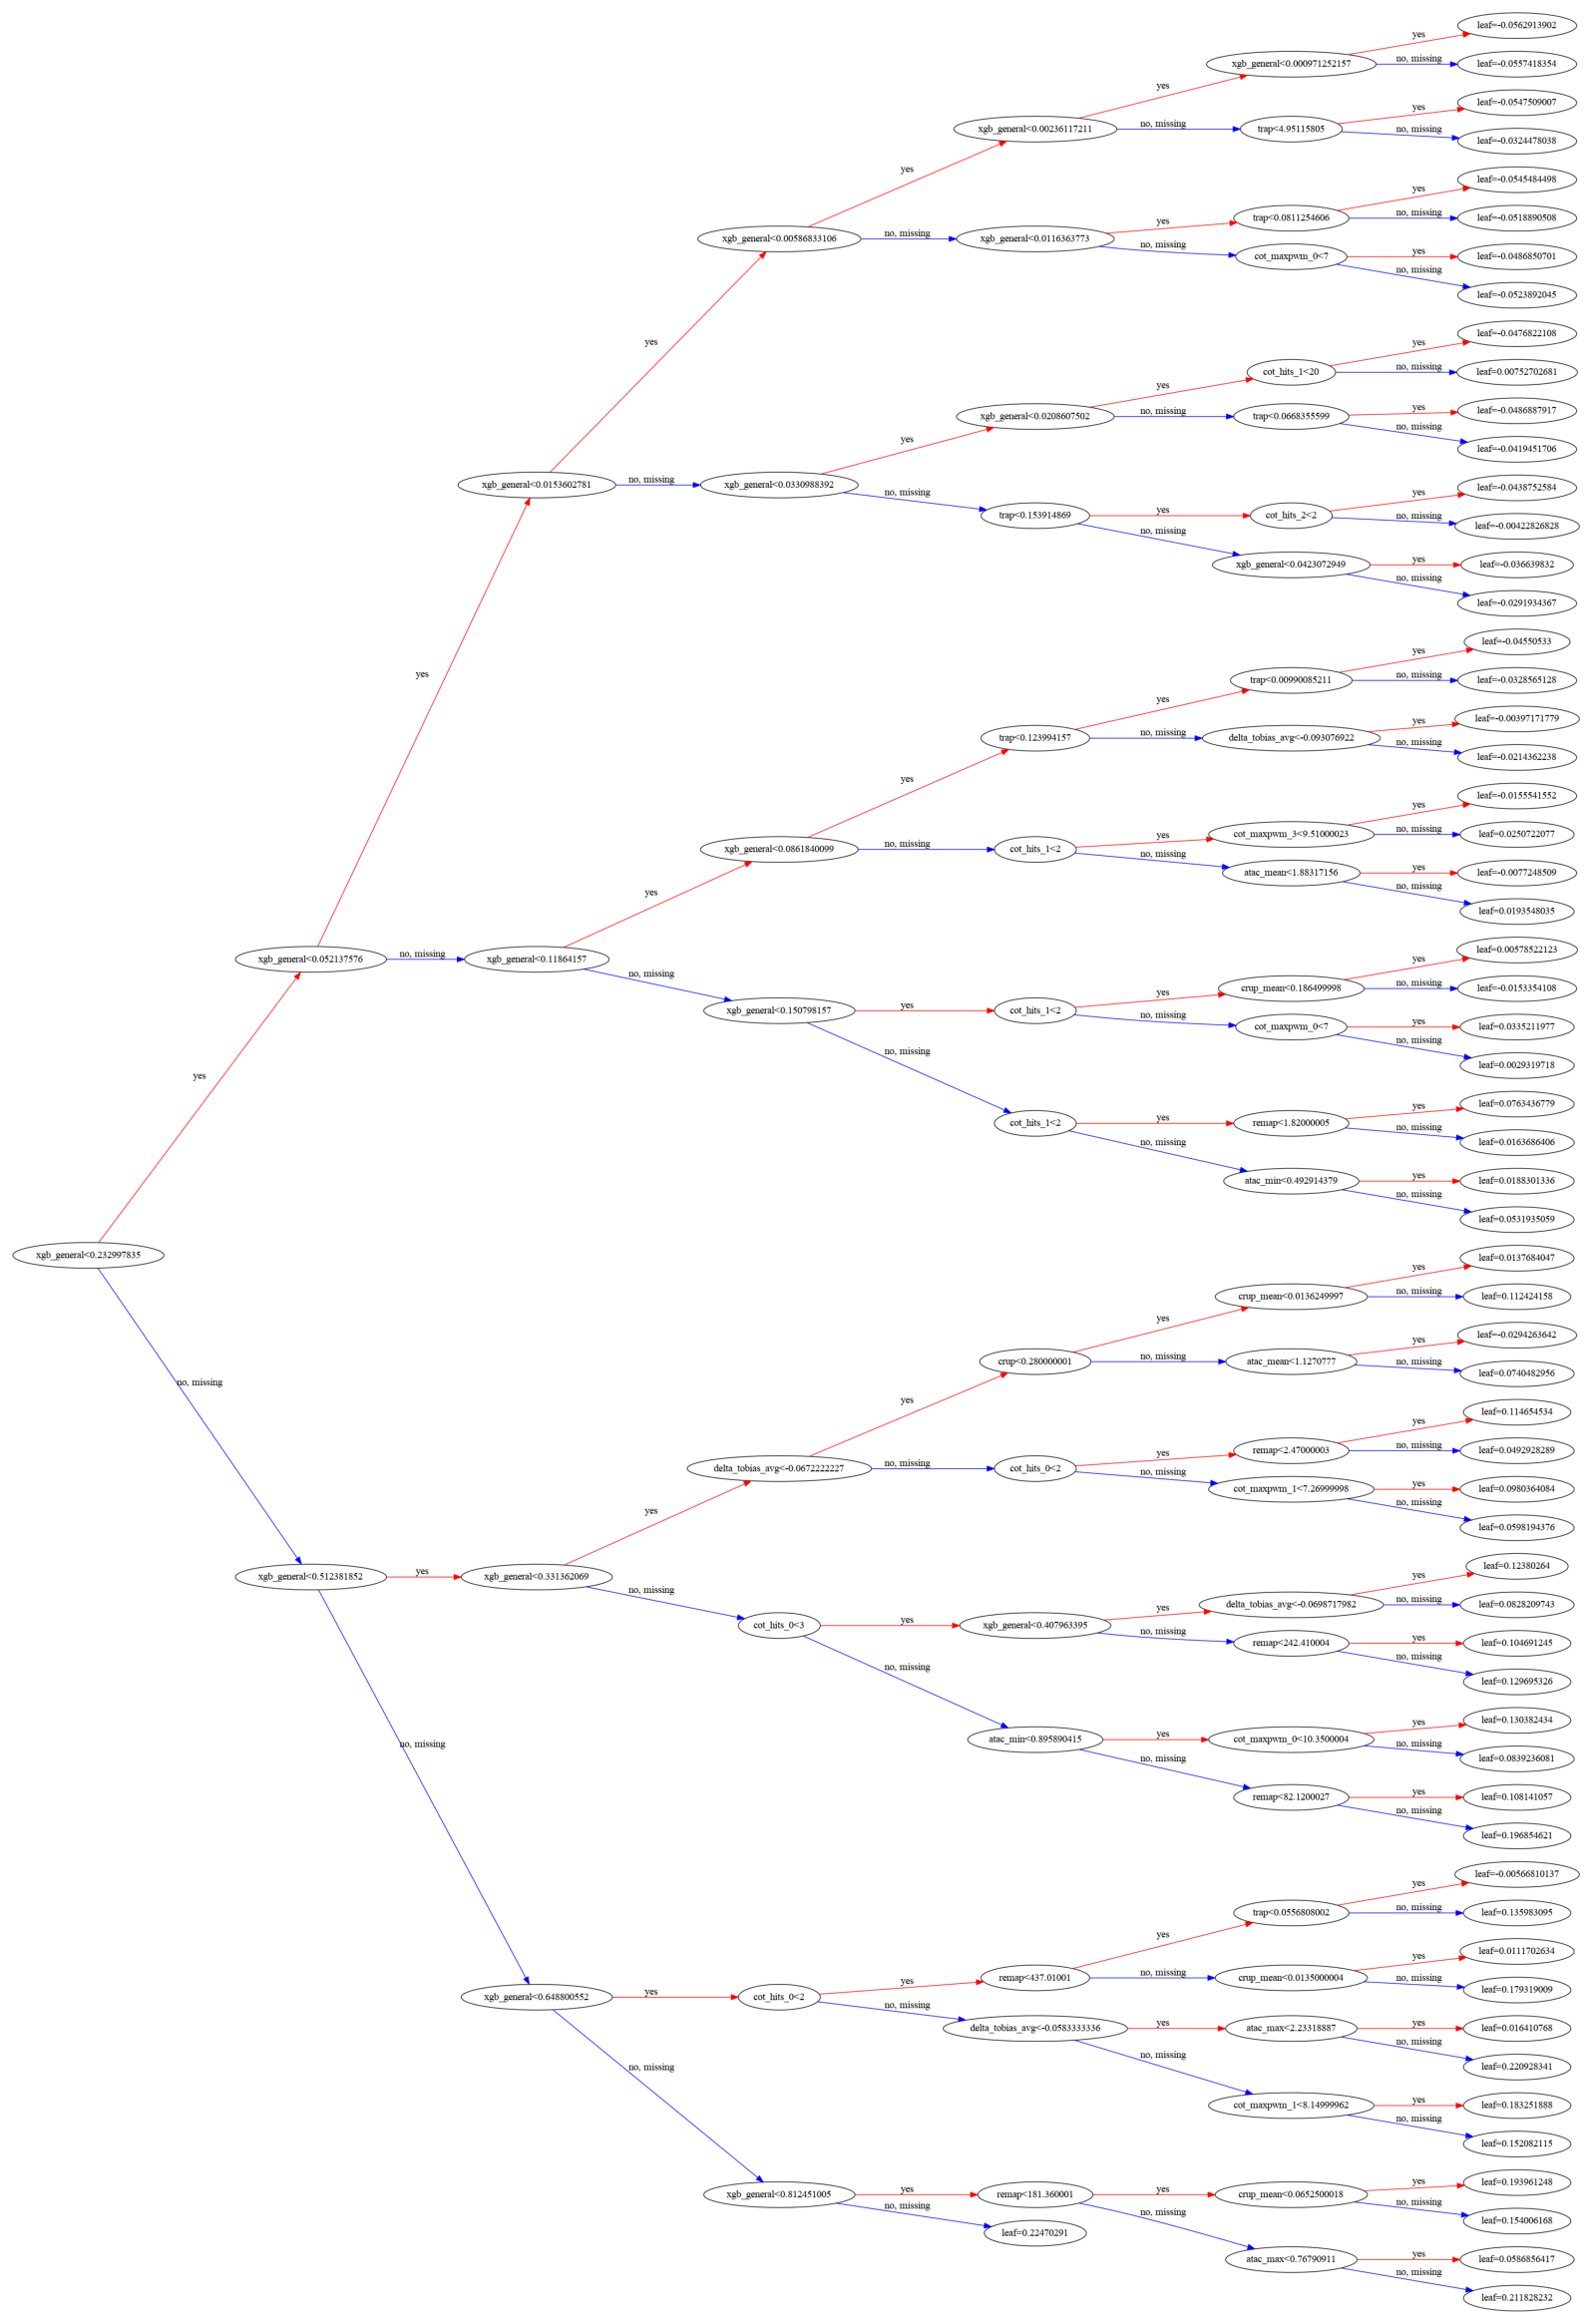

In [900]:
fig, ax = plt.subplots(figsize=(21, 30))
xgb.plot_tree(tf_tuned_models['FOXA2'], num_trees=2, rankdir='LR', ax=ax)
plt.savefig('example_tree_foxa2_2.png', dpi=300)